In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
import numpy.ma as ma
import cartopy.crs as ccrs

In [3]:
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 

In [4]:
import plot_topView_contourf as topView
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [5]:
winds = []
with open("../../../Winds/list_files.txt") as file_list:
    for line in file_list:
        winds.append(xr.open_dataset("../../../Winds/ERA_interim/"+line.split("\n")[0]))

In [6]:
windsMerged = xr.merge(winds)

In [7]:
windsMergedSH = windsMerged.sel(latitude=slice(-60, -89.25))

In [13]:
windsMerged = xr.open_mfdataset("/media/data/Datasets/Winds/ERA_interim/*.nc", chunks={'time':7})

In [14]:
windsMergedSH = windsMerged.sel(latitude=slice(-60, -89.25))

In [28]:
def compute_stress_curl(windsMergedSH):
    stress_curl = np.zeros_like(windsMergedSH.u10)
    wek = np.zeros_like(windsMergedSH.u10)
    rho0 = 1025
    tauy_x = np.zeros_like(windsMergedSH.u10)
    taux_y = np.zeros_like(windsMergedSH.u10)
    
    delta_lat = abs(float(windsMergedSH.latitude[0] - windsMergedSH.latitude[1]))
    delta_lon = abs(float(windsMergedSH.longitude[0] - windsMergedSH.longitude[1]))
    r = 6371e3 # radius of earth in metres
    dy = float(r * np.deg2rad(windsMergedSH.latitude[0] - windsMergedSH.latitude[1]))
    omega = 2*np.pi/(24.*3600)
    f = 2. * omega * np.sin(np.deg2rad(windsMergedSH.latitude.values))
    time_counter = 0
    for t in windsMergedSH.time:
    
        lat_counter = 0
        for lat in windsMergedSH.latitude:
            
            dx = float(r * np.cos(np.deg2rad(lat) ) * delta_lon)
        
            tauy_x[time_counter, lat_counter] = np.gradient(windsMergedSH.sel(time = t, latitude=lat).inss , dx)
            lat_counter+=1
        _, taux_y[time_counter] = np.gradient(windsMergedSH.sel(time = t).iews , dx, dy)
        stress_curl[time_counter] = tauy_x[time_counter] - taux_y[time_counter]
        
        for l in range(len(windsMergedSH.latitude)):
            wek[time_counter, l] = stress_curl[time_counter, l] / (f[l] * rho0)
        time_counter += 1
    
    
    windEk = xr.Dataset({'stressCurl':(['time', 'latitude', 'longitude'], stress_curl), 
                         'wek':(['time', 'latitude', 'longitude'], wek) }, 
                        coords={'time': windsMergedSH.time, 'latitude': windsMergedSH.latitude, 
                               'longitude': windsMergedSH.longitude})
    return windEk

In [47]:
windEk = compute_stress_curl(windsMergedSH)

In [30]:
windEk.to_netcdf("/media/data/Datasets/Winds/wek_ERA_interim_2004_2017.nc")

In [52]:
windEk

<xarray.Dataset>
Dimensions:     (latitude: 40, longitude: 480, time: 168)
Coordinates:
  * longitude   (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * time        (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2017-12-01
  * latitude    (latitude) float32 -60.0 -60.75 -61.5 ... -87.75 -88.5 -89.25
Data variables:
    stressCurl  (time, latitude, longitude) float32 ...
    wek         (time, latitude, longitude) float32 ...

In [62]:
windEk = xr.open_dataset("/media/data/Datasets/Winds/wek_ERA_interim_2004_2017.nc", chunks={'time':10})

In [19]:
import plot_bathymetryGradients as pbgrad
importlib.reload(pbgrad)

<module 'plot_bathymetryGradients' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_bathymetryGradients.py'>

In [20]:
bathy_gradient = pbgrad.compute_bathymetryGradients(lonstep=5, latstep=1)

In [21]:
bathy = xr.open_dataset('/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc')

In [22]:
lonlen = len(bathy.lon)
lonindices = np.arange(0, lonlen+1, 5) # lonstep=5, every 5th longitude
lonindices[-1] = lonindices[-1] - 1
bathyS = bathy.isel(lon=lonindices, lat=np.arange(0, 3600, 1))

In [23]:
bathy_gradient = ma.masked_array(np.array(bathy_gradient))
bathy_gradient.mask = (bathy_gradient < 0.002) | (bathyS.elevation < -3500) | (bathyS.elevation > -800)

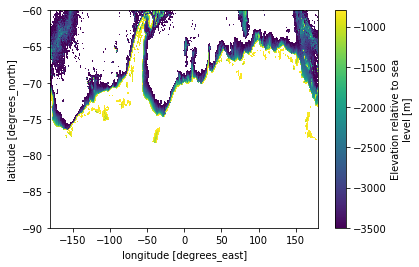

In [24]:
bathyS.where(~bathy_gradient.mask).elevation.plot()
plt.show()

In [66]:
windEk.wek.sel(time="2004-01-01").mean()

TypeError: Invalid array type: <class 'dask.array.core.Array'>

2005
1
2
3
4
5
6
7
8
9
10
11
12


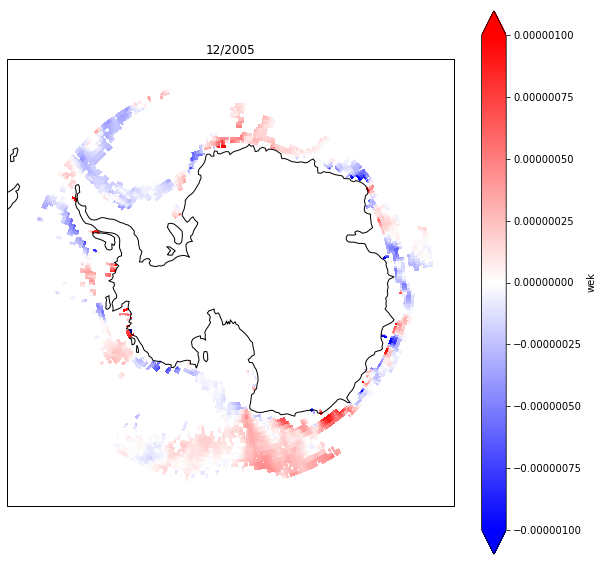

In [50]:
bathylons = bathyS.lon.values
bathylons[bathylons < 0] = bathylons[bathylons < 0] + 360

for i in range(2005, 2006, 1):
    print(i)
    sliced_windek = windEk.wek.sel(time=slice(str(i)+"-01-01", str(i)+"-12-31"))
    slope_wek = sliced_windek.groupby(sliced_windek.time.dt.month).mean(dim=['time']).sel(latitude=bathyS.lat.values, 
                                      longitude=bathylons, method='nearest').where(~bathy_gradient.mask)

    slope_wek = slope_wek.sortby(slope_wek.longitude)
    for m in range(1,13,1):
        print(m)
        plt.close(1)
        fig = plt.figure(1, figsize=(10,10))
        mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0))
        slope_wek.sel(month=m).plot(ax=mapax, vmin=-1e-6, vmax=1e-6, cmap='bwr', 
               transform=ccrs.PlateCarree(), extend='both')
        mapax.coastlines()
        mapax.set_title(str(m)+"/"+str(i))
        plt.savefig("./Images/wind/animations/wek/"+str(m)+"_"+str(i)+".png")
    

In [31]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

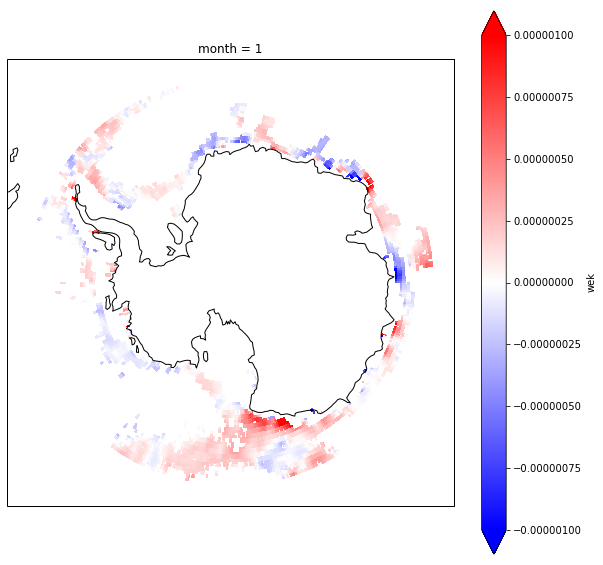

In [97]:
plt.close(1)
fig = plt.figure(1, figsize=(10,10))
mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0))
#CFwek = mapax.contourf(slope_wek.longitude, slope_wek.latitude, slope_wek, vmin=-1e-6, vmax=1e-6, cmap='bwr', 
#               transform=ccrs.PlateCarree(), extend='both')
slope_wek.sel(month=1).plot(ax=mapax, vmin=-1e-6, vmax=1e-6, cmap='bwr', 
               transform=ccrs.PlateCarree(), extend='both')
mapax.coastlines()
#plt.colorbar(CFwek)
plt.show()